
Missing values in Data:
Body Size               0
Body Weight             0
Height                  0
Bone Structure          0
Complexion              0
General feel of skin    0
Texture of Skin         0
Hair Color              0
Appearance of Hair      0
Shape of face           0
Eyes                    0
Eyelashes               0
Blinking of Eyes        0
Cheeks                  0
Nose                    0
Teeth and gums          0
Lips                    0
Nails                   0
Appetite                0
Liking tastes           0
Dosha                   0
dtype: int64
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters from Grid Search:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (Best Model): 91.25%

Classification Report (Best Model):
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.89        51
         1.0       0.93      0.93      0.93        30
         2.0       1.00      0.82      0.9

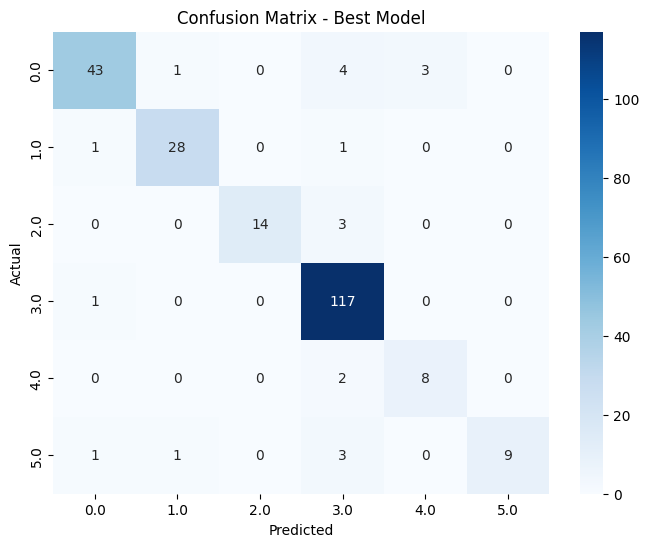

Cross-Validation Accuracy: 91.92%


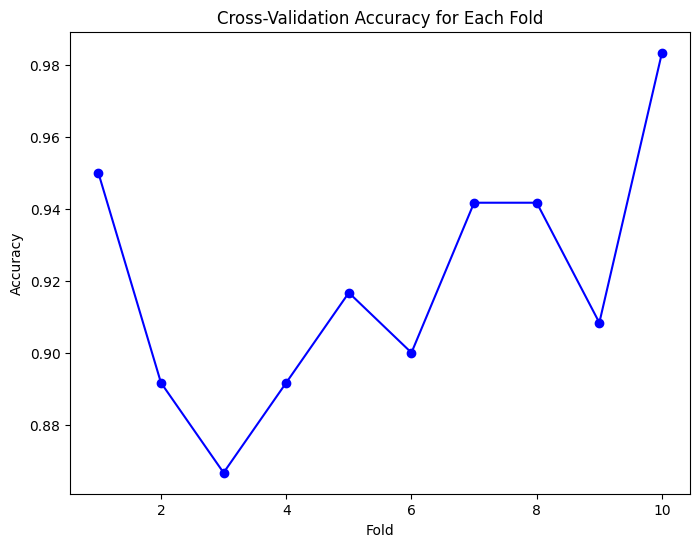

Best model saved successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import random
np.random.seed(42)
random.seed(42)

# Load the dataset
data = pd.read_csv(r'D:\mini project\sem VI\project\bot\data\raw\data.csv')

# Check for missing values
print("\nMissing values in Data:")
print(data.isnull().sum())

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Define features (X) and labels (y)
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Labels (Last column as output)

# Encode categorical data if present
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Add Gaussian noise to the features
def add_gaussian_noise(X, mean=0, std=0.1):
    noise = np.random.normal(mean, std, X.shape)  # mean, std, and shape of the data
    X_noisy = X + noise
    return X_noisy

# Adding noise to the feature data
X_noisy = add_gaussian_noise(X)

# Add noise to the labels (class labels)
def add_label_noise(y, noise_level=0.1):
    n_samples = len(y)
    noise_count = int(n_samples * noise_level)  # Number of noisy labels
    noisy_indices = np.random.choice(n_samples, noise_count, replace=False)
    
    # Shuffle the labels of the selected noisy samples
    noisy_labels = np.random.choice(np.unique(y), noise_count)  # Choose random labels
    y_noisy = y.copy()
    y_noisy[noisy_indices] = noisy_labels  # Replace noisy labels
    return y_noisy

# Adding noise to the labels
y_noisy = add_label_noise(y, noise_level=0.1)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42, stratify=y_noisy)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to avoid retraining it in future
joblib.dump(scaler, 'scaler_best.pkl')


# Hyperparameter tuning for SVM with RBF kernel
param_grid = {
    'C': [0.1, 1, 10],  # Try different values for C
    'gamma': ['scale', 'auto', 0.1, 1],  # Try different values for gamma
    'kernel': ['rbf']   # Only use RBF kernel for this example
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from Grid Search
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Test Accuracy (Best Model): {accuracy_best * 100:.2f}%")

# Classification report and confusion matrix for the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_noisy, y_noisy, cv=10)
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Visualize cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b')
plt.title("Cross-Validation Accuracy for Each Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

# Save the trained best model
try:
    joblib.dump(best_model, 'svc_rbf_best_model.pkl')
    print("Best model saved successfully!")
except Exception as e:
    print(f"Error while saving the model: {e}")

# Load model (optional check for later usage)
# loaded_model = joblib.load('svc_rbf_best_model.pkl')
